# decappingQuantification2_perGenePlots.ipynb
## Marcus Viscardi,    July 12, 2024

Check out `README.md` for a more overarching view of what is happening here.

The `decappingQuantification.ipynb` script was getting REALLY bloated.
This script trys to take the parts of that script that were related to producing plots for individual genes and moves them here.

In [3]:
from typing import Tuple

import nanoporePipelineCommon as npCommon

import numpy as np
import pandas as pd

import re

import seaborn as sea
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from tqdm.auto import tqdm

from icecream import ic
from datetime import datetime

from pathlib import Path

from scipy.stats import mannwhitneyu, ks_2samp

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

def __time_formatter__():
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"ic: {now} | > "
ic.configureOutput(prefix=__time_formatter__)

_ = ic("Imports done!")

ic: 2024-08-21 12:16:09 | > 'Imports done!'


In [4]:
gtf_parquet_path = Path("/data16/marcus/genomes/plus_cerENO2_elegansRelease100/230327_allChrs_plus-cerENO2.gtf.parquet")

gtf_df = pd.read_parquet(gtf_parquet_path)

current_dir = Path.cwd()

In [5]:
obj_dict = {}
libs_to_run = [
    "oldN2",
    # "oldS6",
    "newerN2",
    "newerS6",
    "newerS5",
    "thirdN2",
    "thirdS5",
    "thirdS6",
    "temp25cN2",
    "temp25cS5",
    "temp25cS6",
    "temp25cS7",
]
for lib in libs_to_run:
    print(f"\nLoading {lib}...", end="")
    obj = npCommon.NanoporeRun(run_nickname=lib)
    obj_dict[lib] = obj
    print(" Done!")
    # obj.load_mergedOnReads()  # I actually don't need this for this script...
    obj.load_nmd_targets(return_sambamobj=False)


Loading oldN2... Done!

Loading newerN2... Done!

Loading newerS6... Done!

Loading newerS5... Done!

Loading thirdN2... Done!

Loading thirdS5... Done!

Loading thirdS6... Done!

Loading temp25cN2... Done!

Loading temp25cS5... Done!

Loading temp25cS6... Done!

Loading temp25cS7... Done!


In [6]:
genes = [
    'rps-22',
    'ubl-1',
    'rpl-30',
    # 'eef-1A.1',  # rev  # Something weird is going on...
    'rla-1',  # rev
    'rps-25',  # rev
    'Y37E3.8',  # rev
    'rpl-10',
    'rla-0',
    'rpl-18',
    'rps-3',
    'rpl-38',
    'rpl-24.1',
    # NMD Targets:
    # 'rpl-30',
    # 'ubl-1',
    # 'rps-22',
    'hel-1',
    'rpl-7A',
    'ZK228.4',
    'R06C1.4',
    'rpl-12',
    'pqn-70',
    'rsp-5',
    'rpl-1',
    'C53H9.2',
    'rpl-3',
    'rsp-6',
    'rpl-26',
    'K08D12.3',
    'aly-3',
]

gene_ids_to_names_dict = gtf_df.query('feature == "gene"').set_index('gene_id')['gene_name'].to_dict()
gene_names_to_ids_dict = gtf_df.query('feature == "gene"').set_index('gene_name')['gene_id'].to_dict()
for gene_name in genes:
    gene_id = gene_names_to_ids_dict[gene_name]
    print(f"{gene_name:>10} -> {gene_id}")
gene_ids = [gene_names_to_ids_dict[gene_name] for gene_name in genes]

    rps-22 -> WBGene00004491
     ubl-1 -> WBGene00006725
    rpl-30 -> WBGene00004444
     rla-1 -> WBGene00004409
    rps-25 -> WBGene00004494
   Y37E3.8 -> WBGene00021350
    rpl-10 -> WBGene00004421
     rla-0 -> WBGene00004408
    rpl-18 -> WBGene00004430
     rps-3 -> WBGene00004472
    rpl-38 -> WBGene00004452
  rpl-24.1 -> WBGene00004436
     hel-1 -> WBGene00001840
    rpl-7A -> WBGene00004419
   ZK228.4 -> WBGene00013947
   R06C1.4 -> WBGene00011059
    rpl-12 -> WBGene00004424
    pqn-70 -> WBGene00004152
     rsp-5 -> WBGene00004702
     rpl-1 -> WBGene00004412
   C53H9.2 -> WBGene00016907
     rpl-3 -> WBGene00004414
     rsp-6 -> WBGene00004703
    rpl-26 -> WBGene00004440
  K08D12.3 -> WBGene00019537
     aly-3 -> WBGene00000122


In [7]:
import pysam

def load_simple_nmd_targets(nmd_targets_path, target_gene_ids_to_names_dict) -> pd.DataFrame:
    target_gene_names_to_ids_dict = {v: k for k, v in target_gene_ids_to_names_dict.items()}
    reads_dict = {}
    with pysam.AlignmentFile(nmd_targets_path, 'rb') as test_bam:
        for read in test_bam.fetch():
            read_assigned_gene_id = read.get_tag('gA')
            # print(read.query_name, read_assigned_gene_id, target_gene_ids_to_names_dict[read_assigned_gene_id], read.get_tag('t5'), read.get_tag('nC'))
            reads_dict[read.query_name] = {
                'gene_id': read_assigned_gene_id,
                'gene_name': target_gene_ids_to_names_dict[read_assigned_gene_id],
                't5': read.get_tag('t5'),
                'nmd_assignment': read.get_tag('nC'),
                'cigar': read.cigarstring,
                'chr_pos': read.reference_start,
                'chr': read.reference_name,
                'seq': read.query_sequence,
            }
    df = pd.DataFrame(reads_dict).T
    return df

nmd_genes = []

for lib, lib_obj in obj_dict.items():
    print(f"Loading {lib} NMD Targets from {lib_obj.nmd_targets_bam_path}...", end="")
    lib_obj.load_nmd_targets(return_sambamobj=False)
    print(" Done!")
    lib_obj.nmd_targets_df = load_simple_nmd_targets(lib_obj.nmd_targets_bam_path, gene_ids_to_names_dict)
    # print(lib_obj.nmd_targets_df.gene_name.unique())
    nmd_genes.extend(lib_obj.nmd_targets_df.gene_name.unique())
nmd_genes = list(set(nmd_genes))
print(nmd_genes)

Loading oldN2 NMD Targets from /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/NMD_targets/240702_nmd_targets.all.merge.bam... Done!
Loading newerN2 NMD Targets from /data16/marcus/working/230327_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA_rerun/output_dir/NMD_targets/240702_nmd_targets.all.merge.bam... Done!
Loading newerS6 NMD Targets from /data16/marcus/working/230403_nanoporeRun_totalRNA_smg-6_xrn-1-KD_5TERA_rerun/output_dir/NMD_targets/240702_nmd_targets.all.merge.bam... Done!
Loading newerS5 NMD Targets from /data16/marcus/working/230410_nanoporeRun_totalRNA_smg-5_xrn-1-KD_5TERA_rerun/output_dir/NMD_targets/240702_nmd_targets.all.merge.bam... Done!
Loading thirdN2 NMD Targets from /data16/marcus/working/230918_nanoporeRun_sMV013_wt_xrn-1-KD_5TERA/output_dir/NMD_targets/240702_nmd_targets.all.merge.bam... Done!
Loading thirdS5 NMD Targets from /data16/marcus/working/230918_nanoporeRun_sMV014_smg-5_xrn-1-KD_5TERA/output_dir/NMD_targets/240702_nmd_target

######################rps-22######################


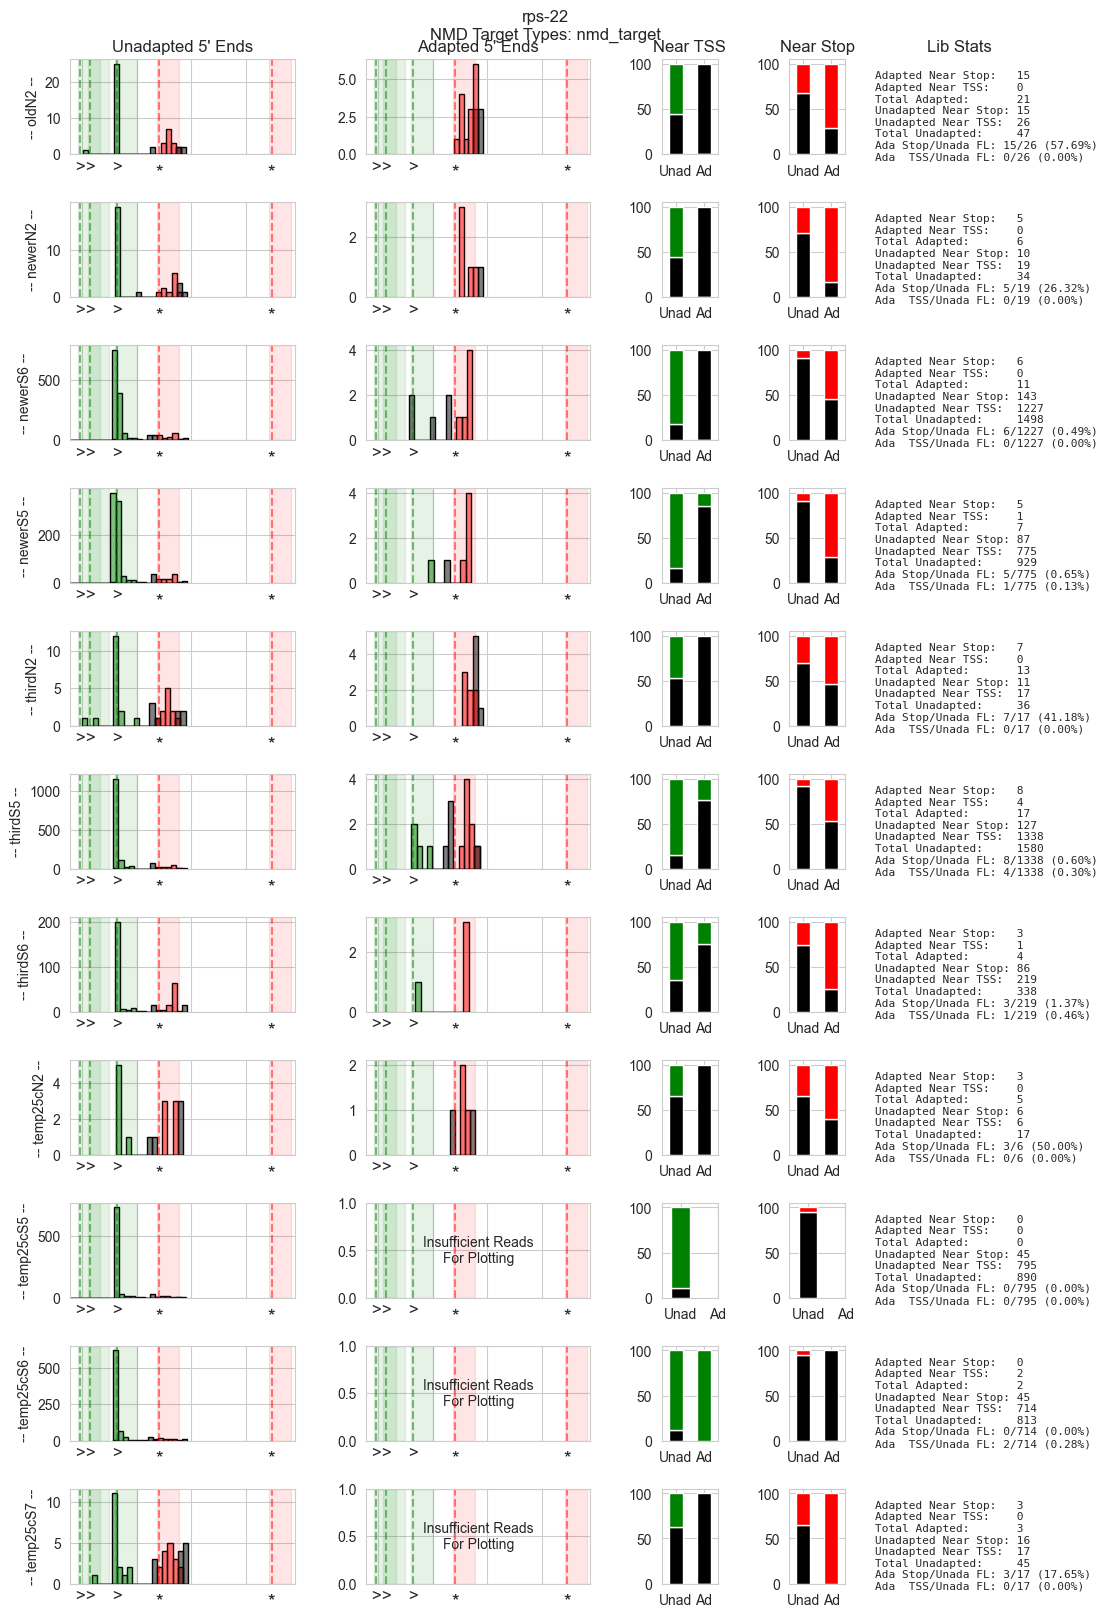

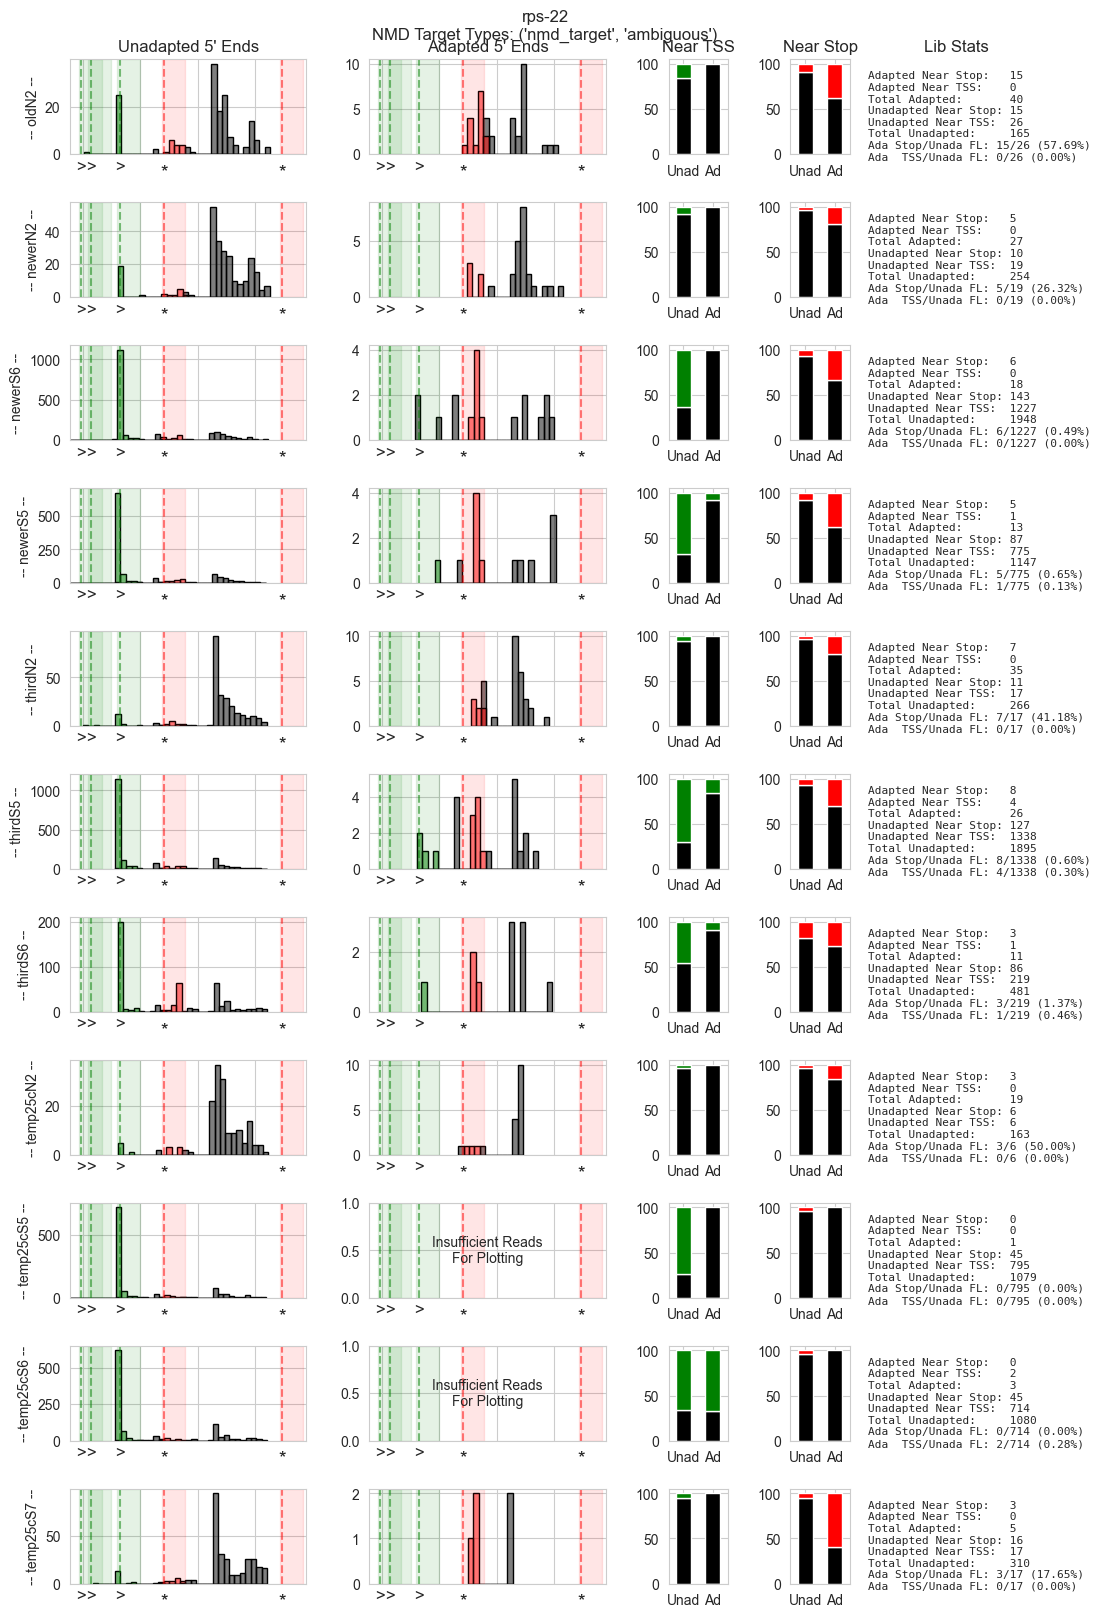

Error: `bins` must be positive, when an integer


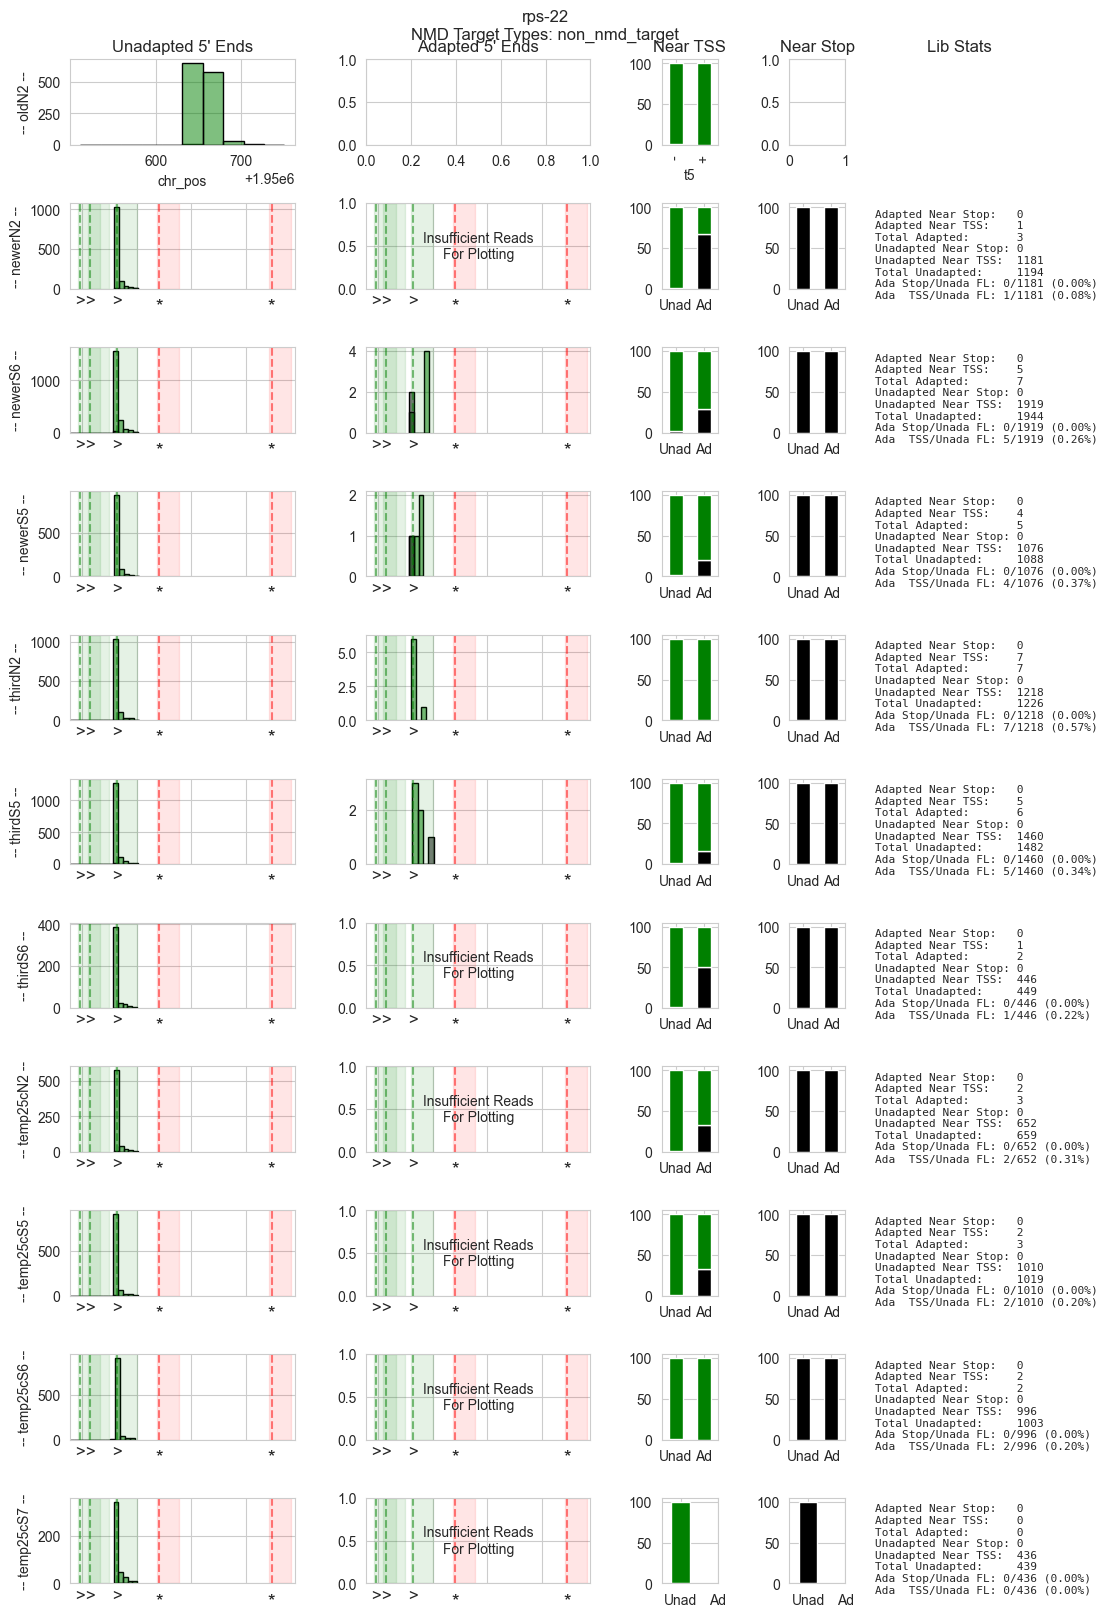

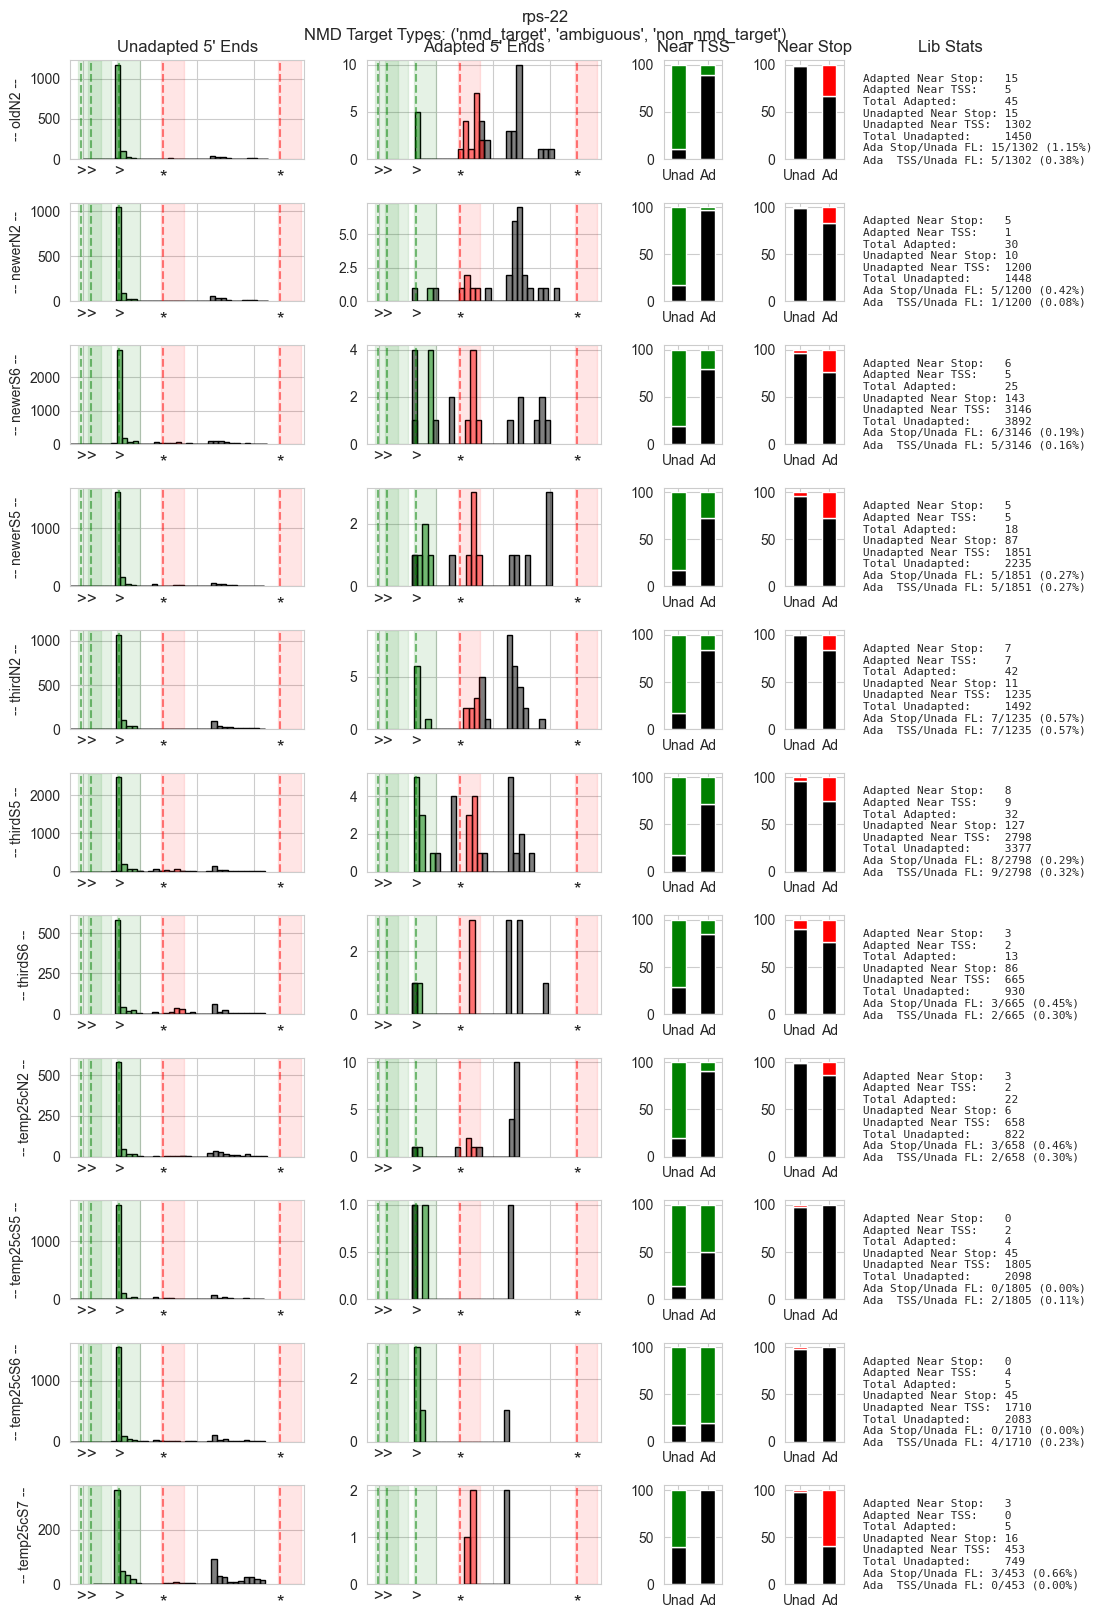

######################ubl-1#######################


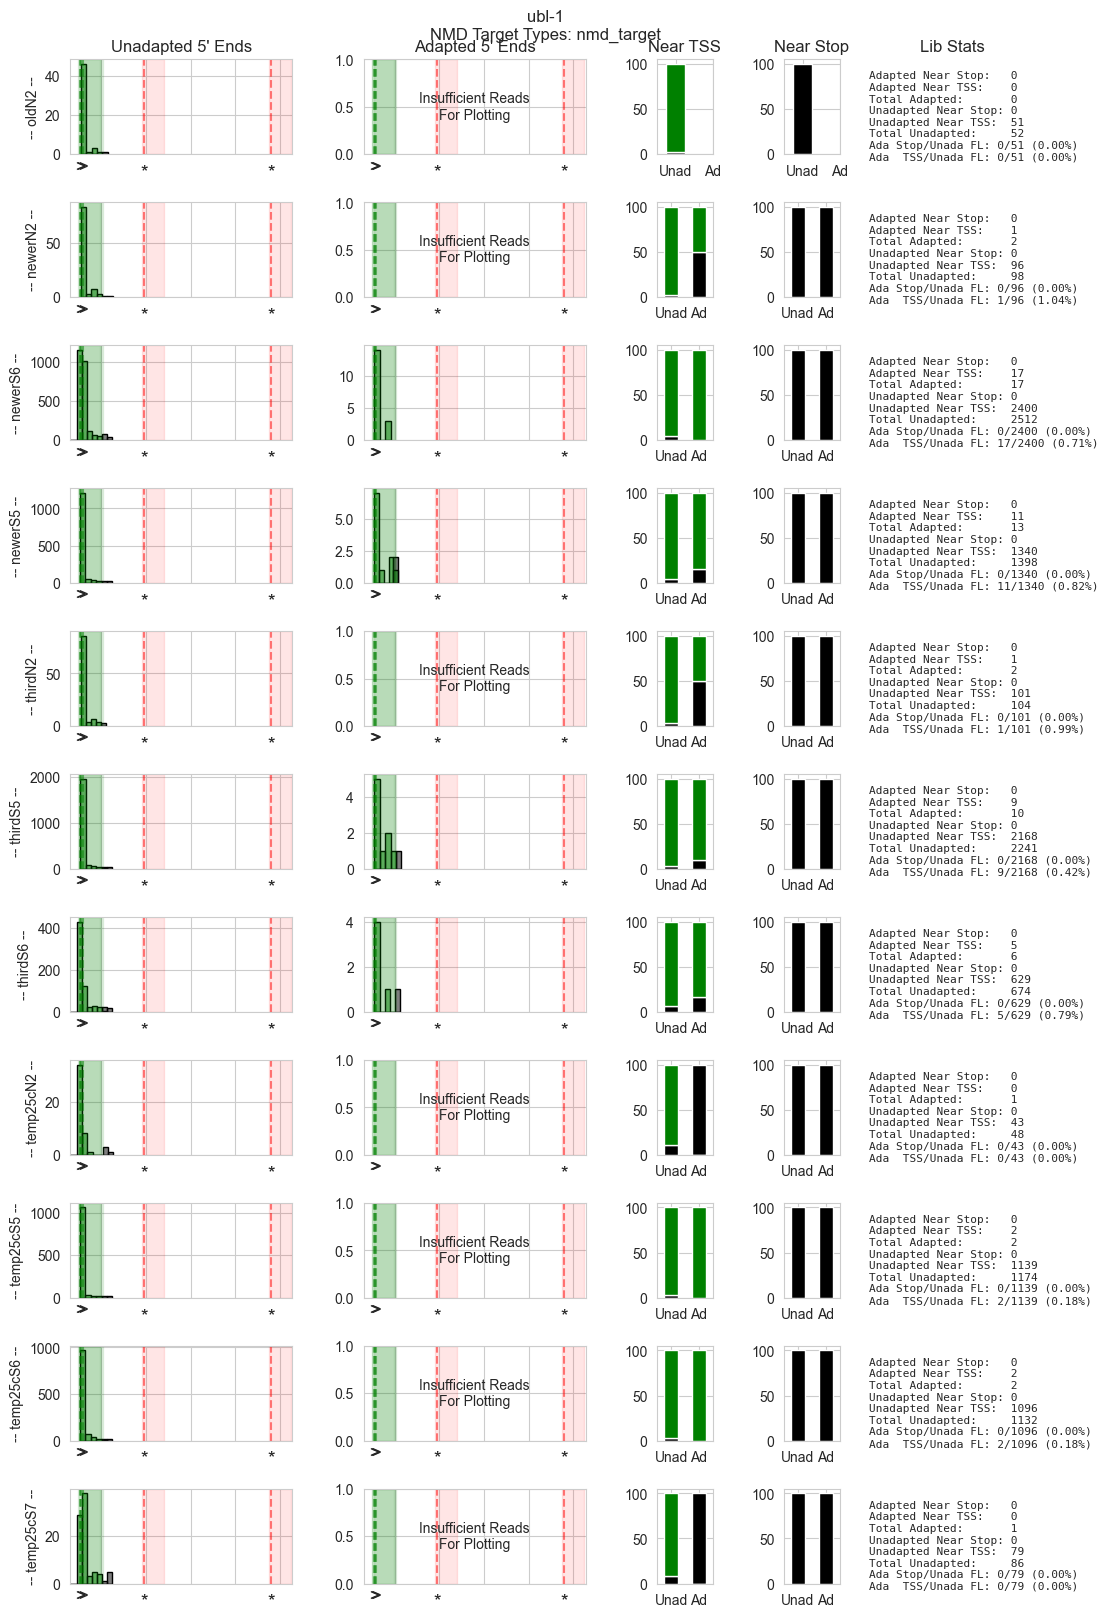

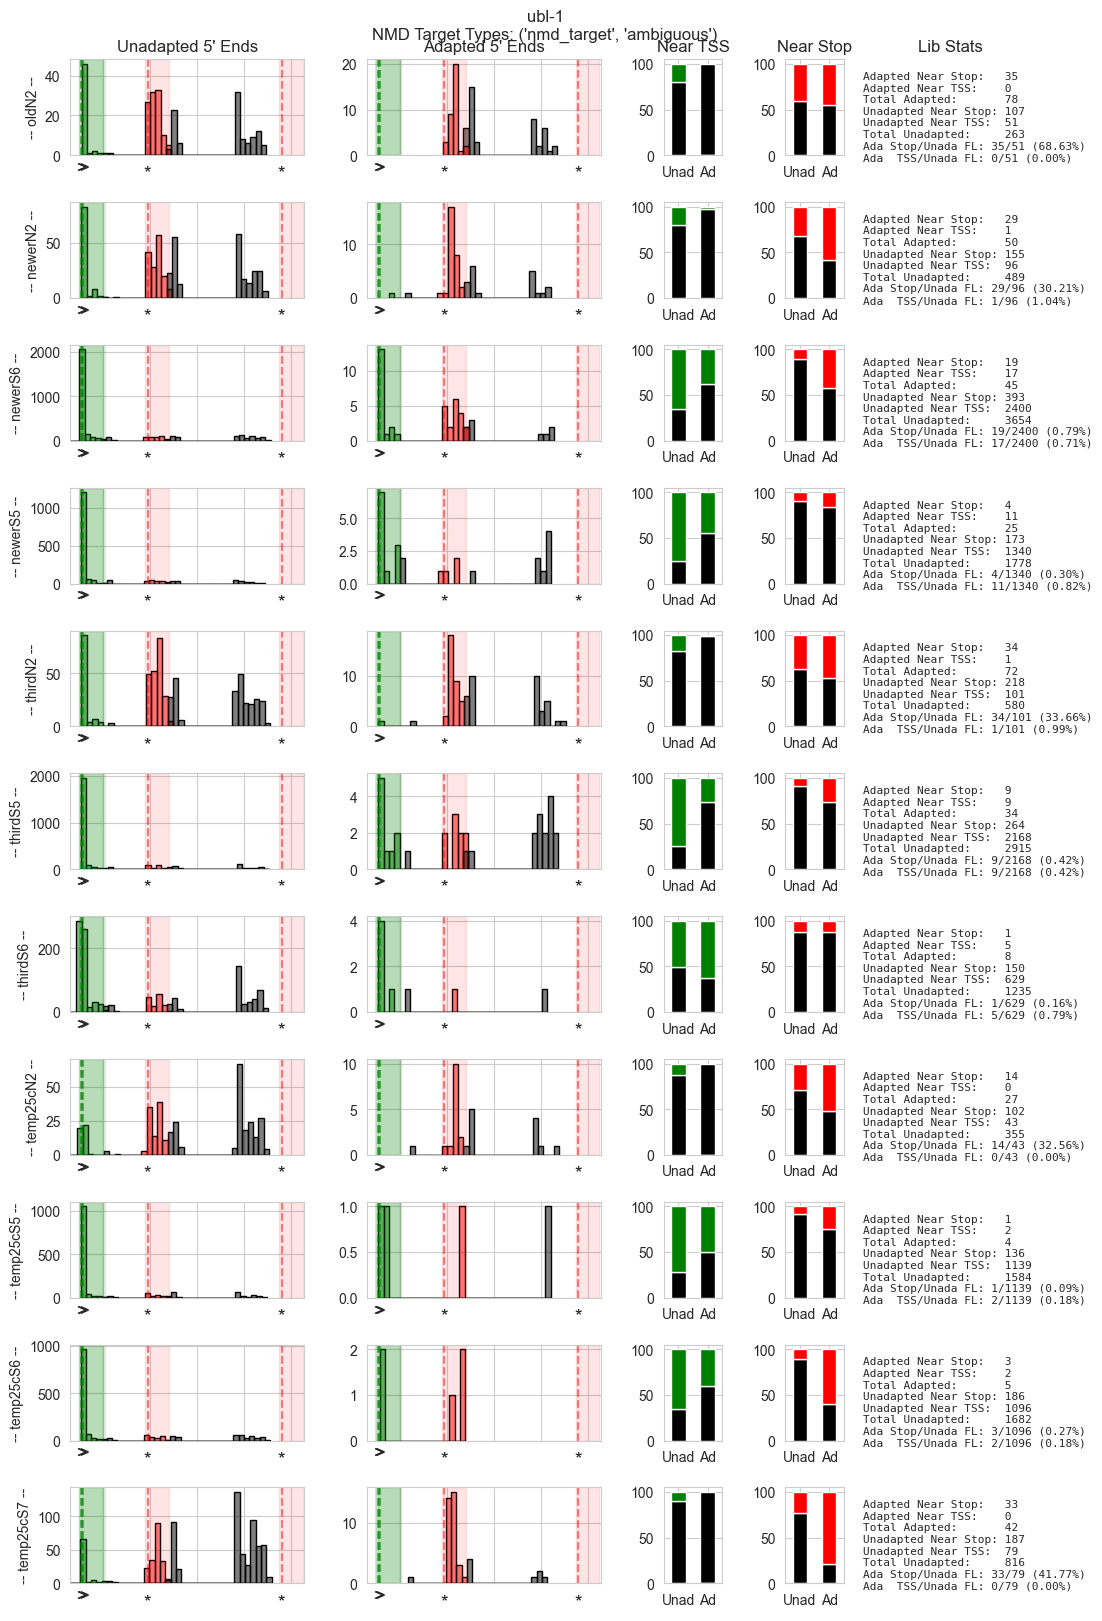

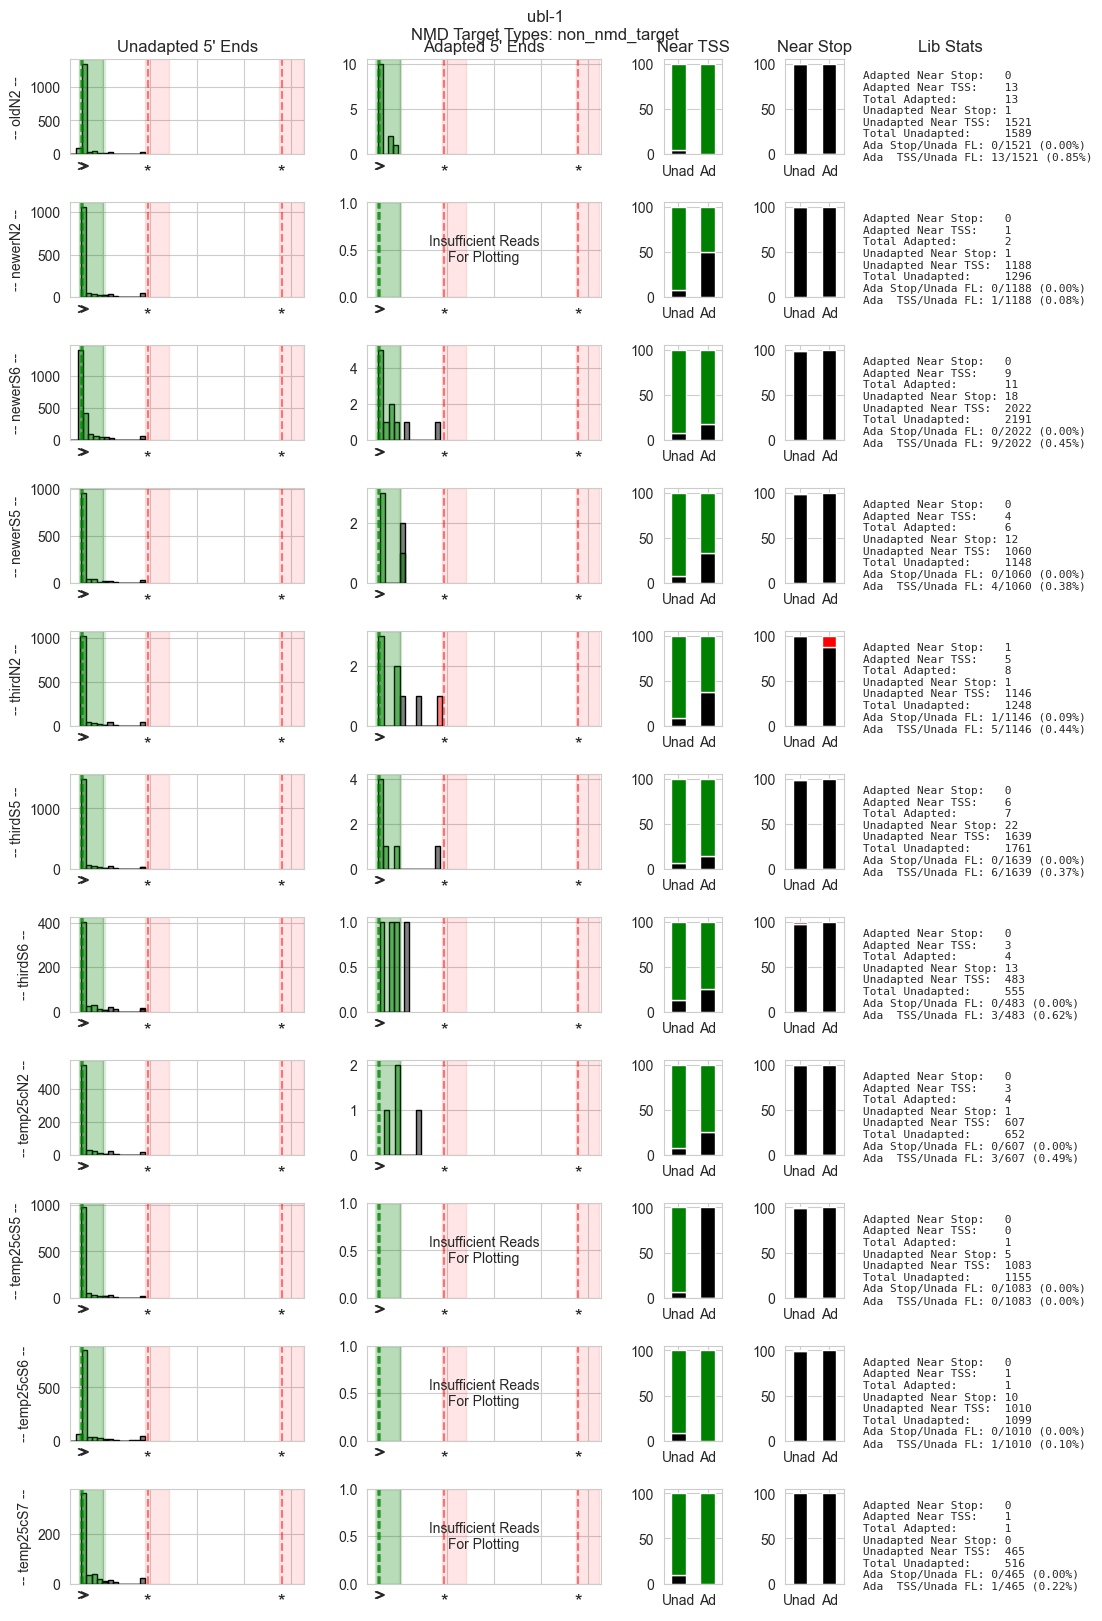

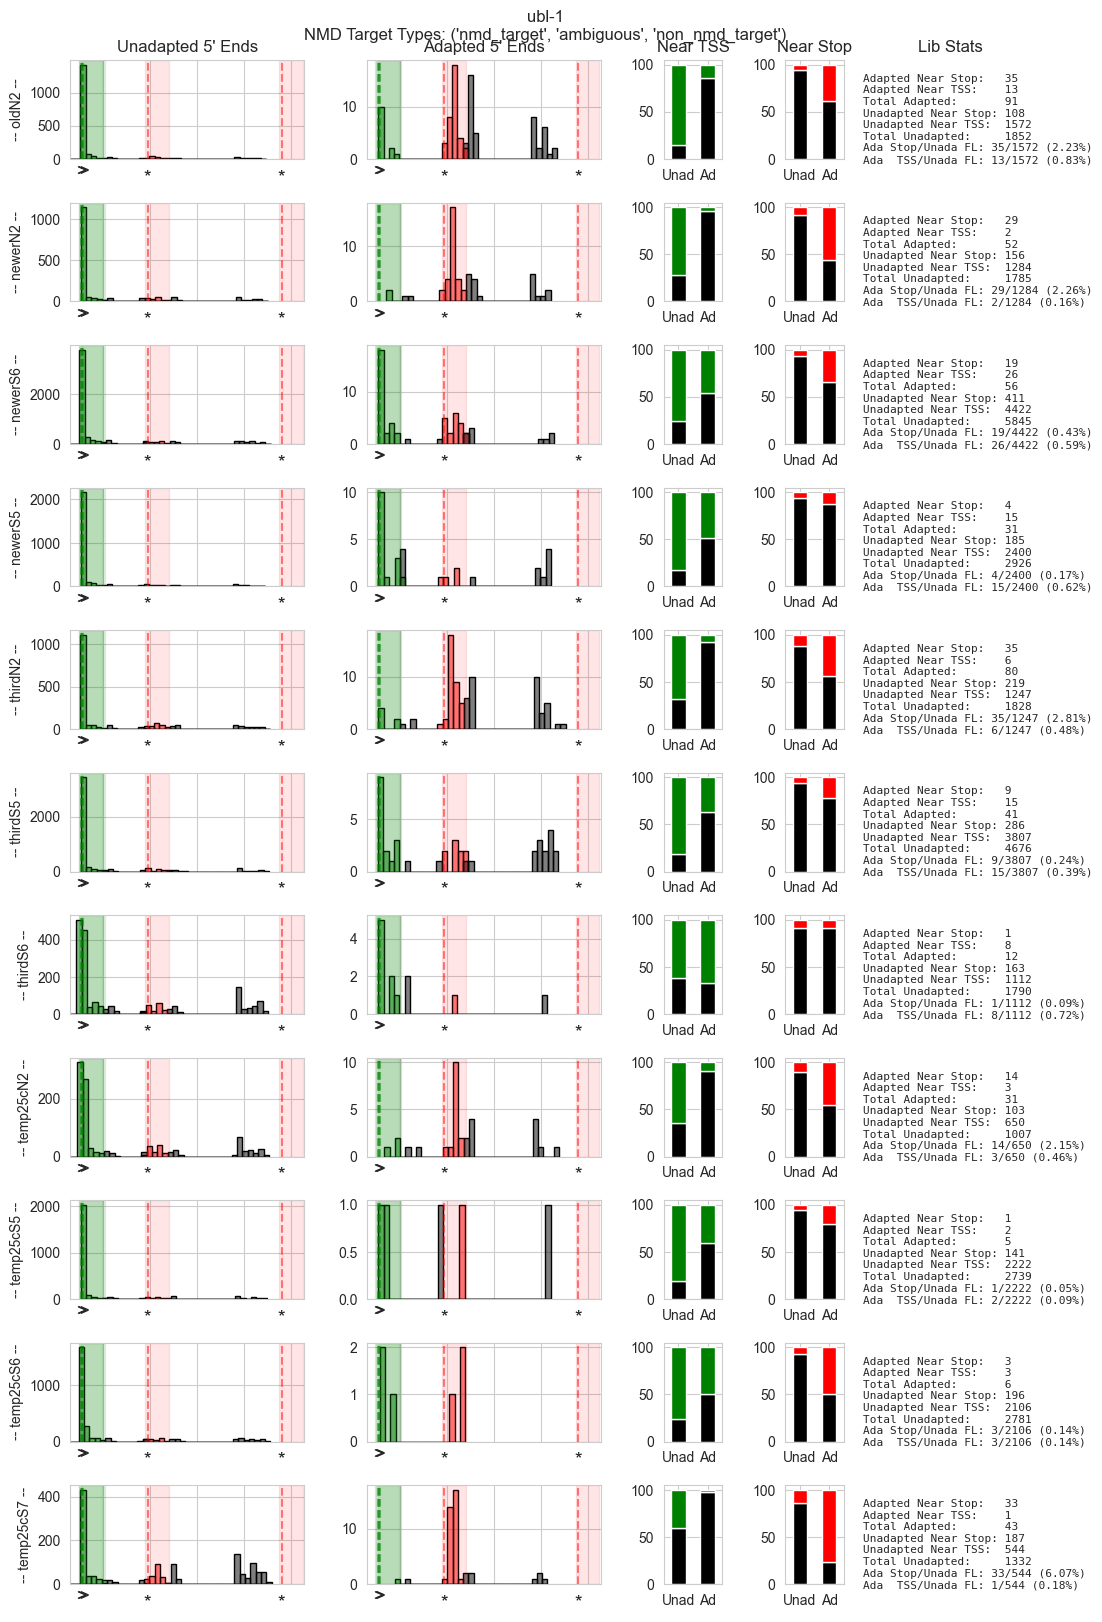

######################rpl-30######################


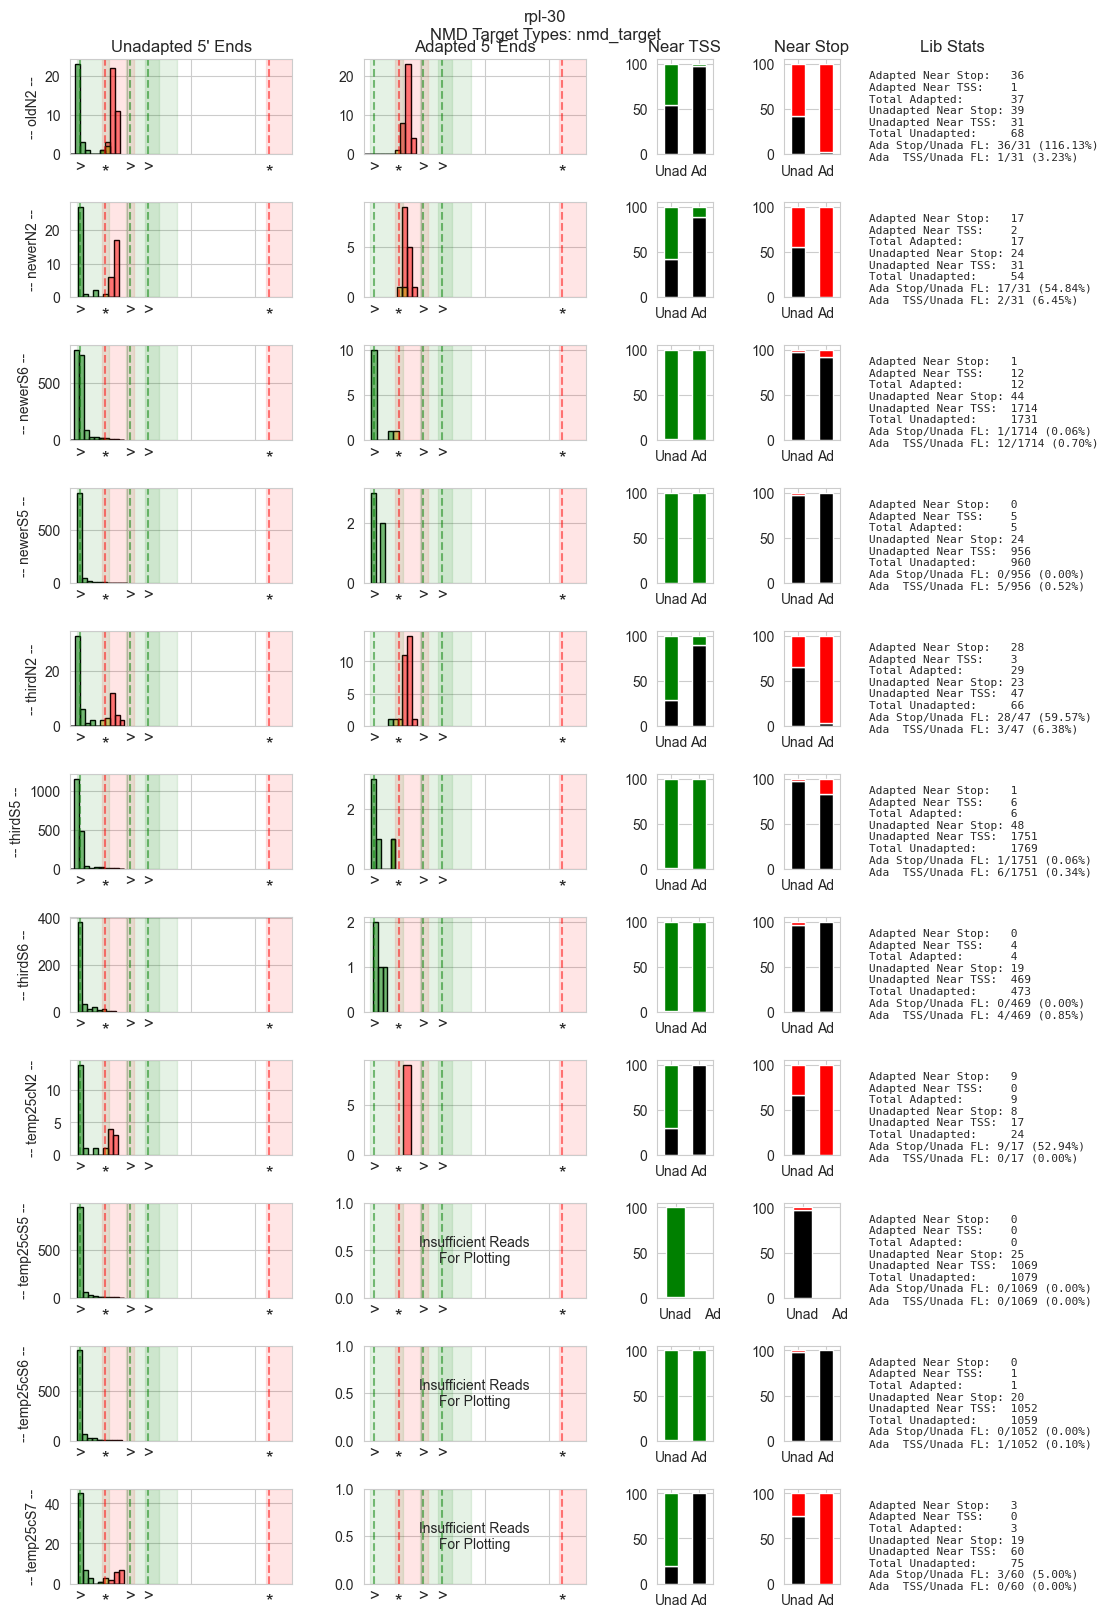

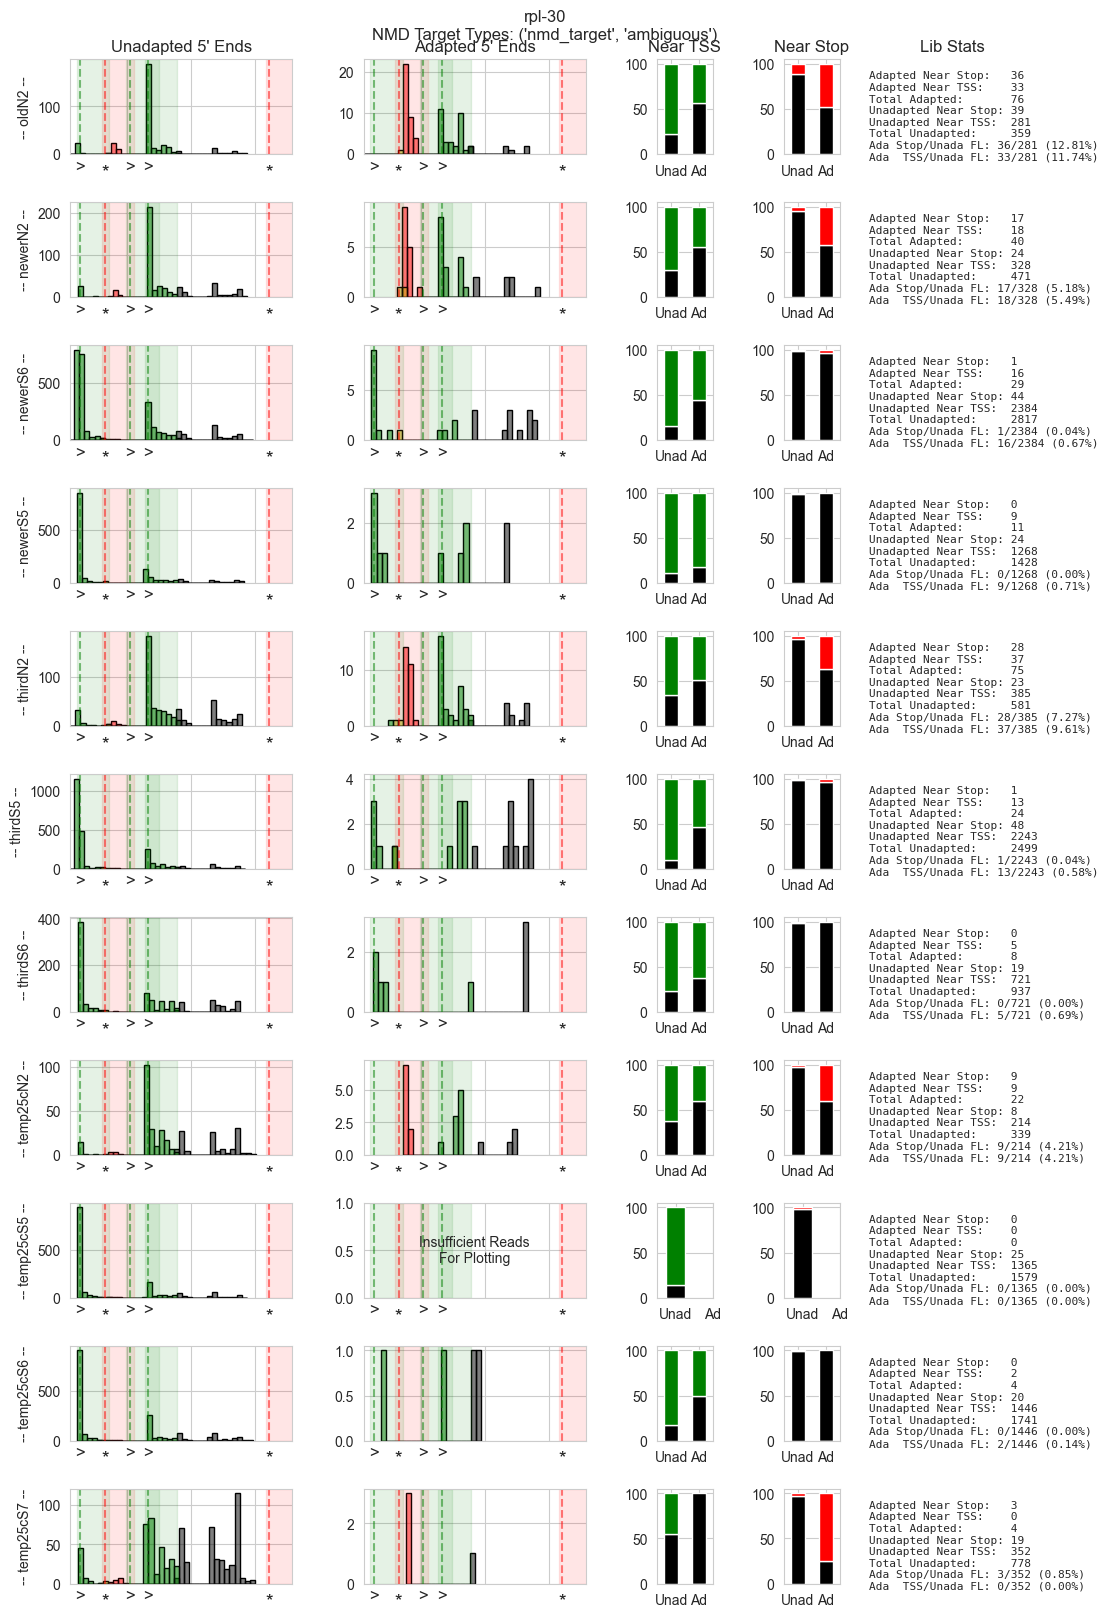

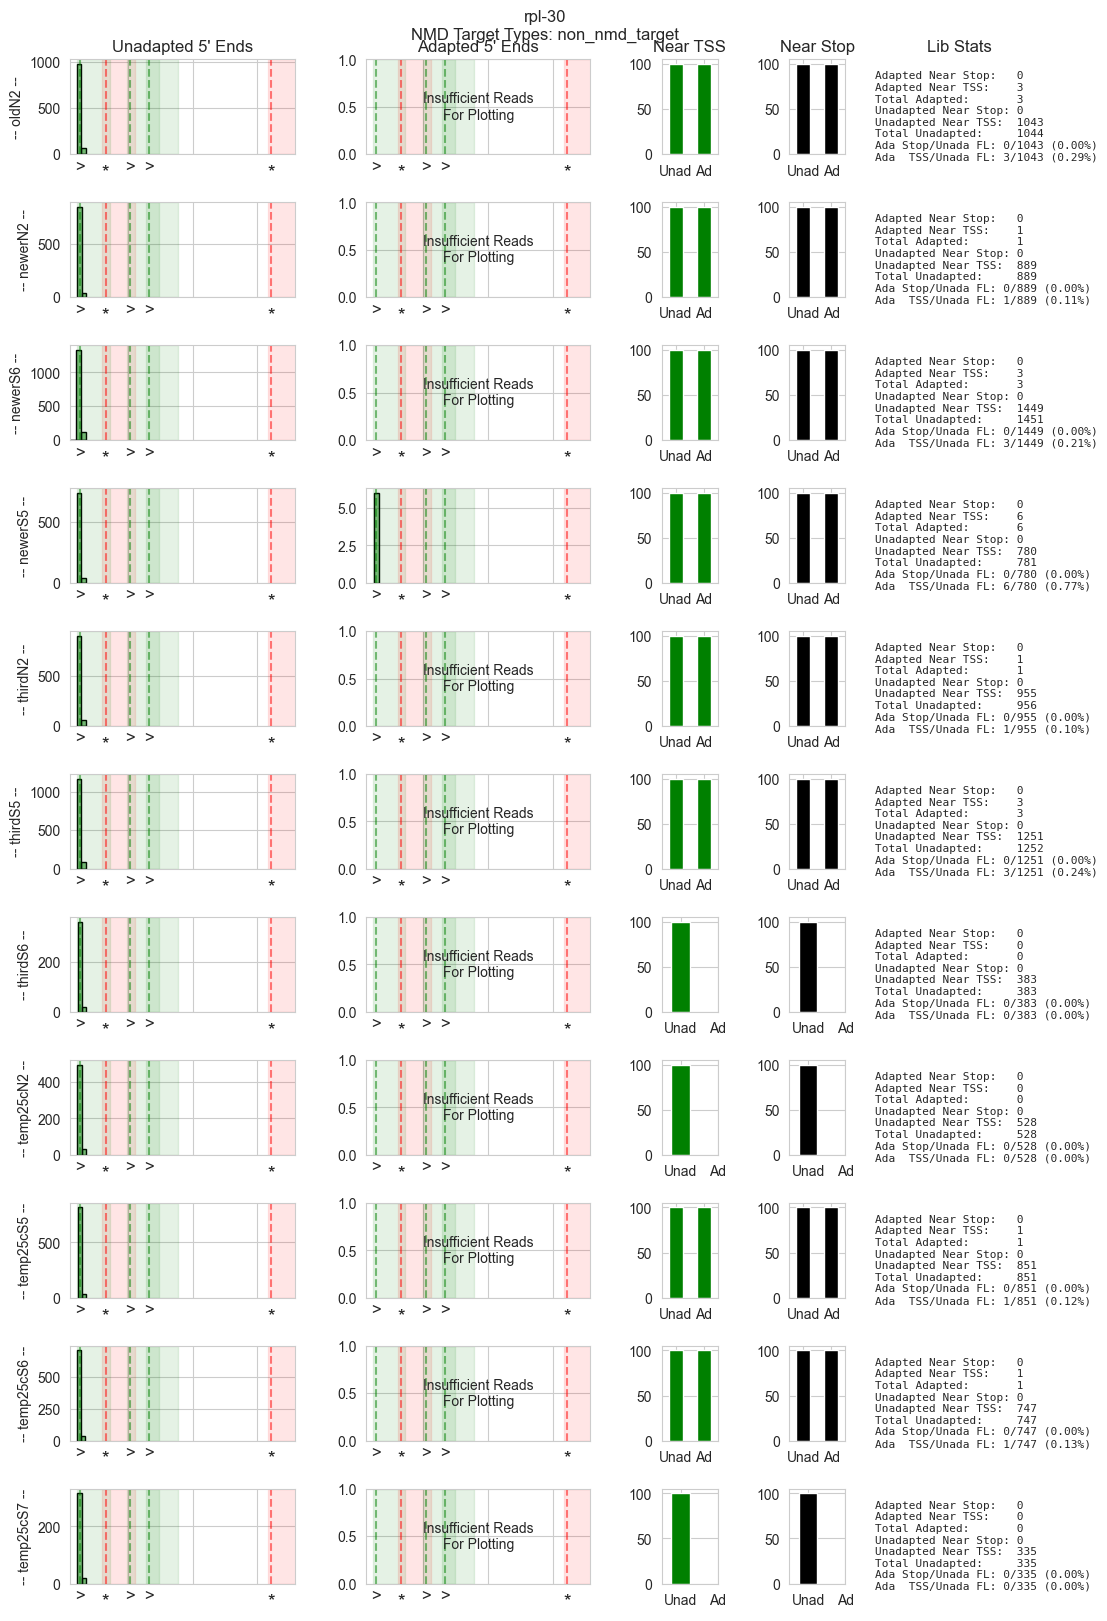

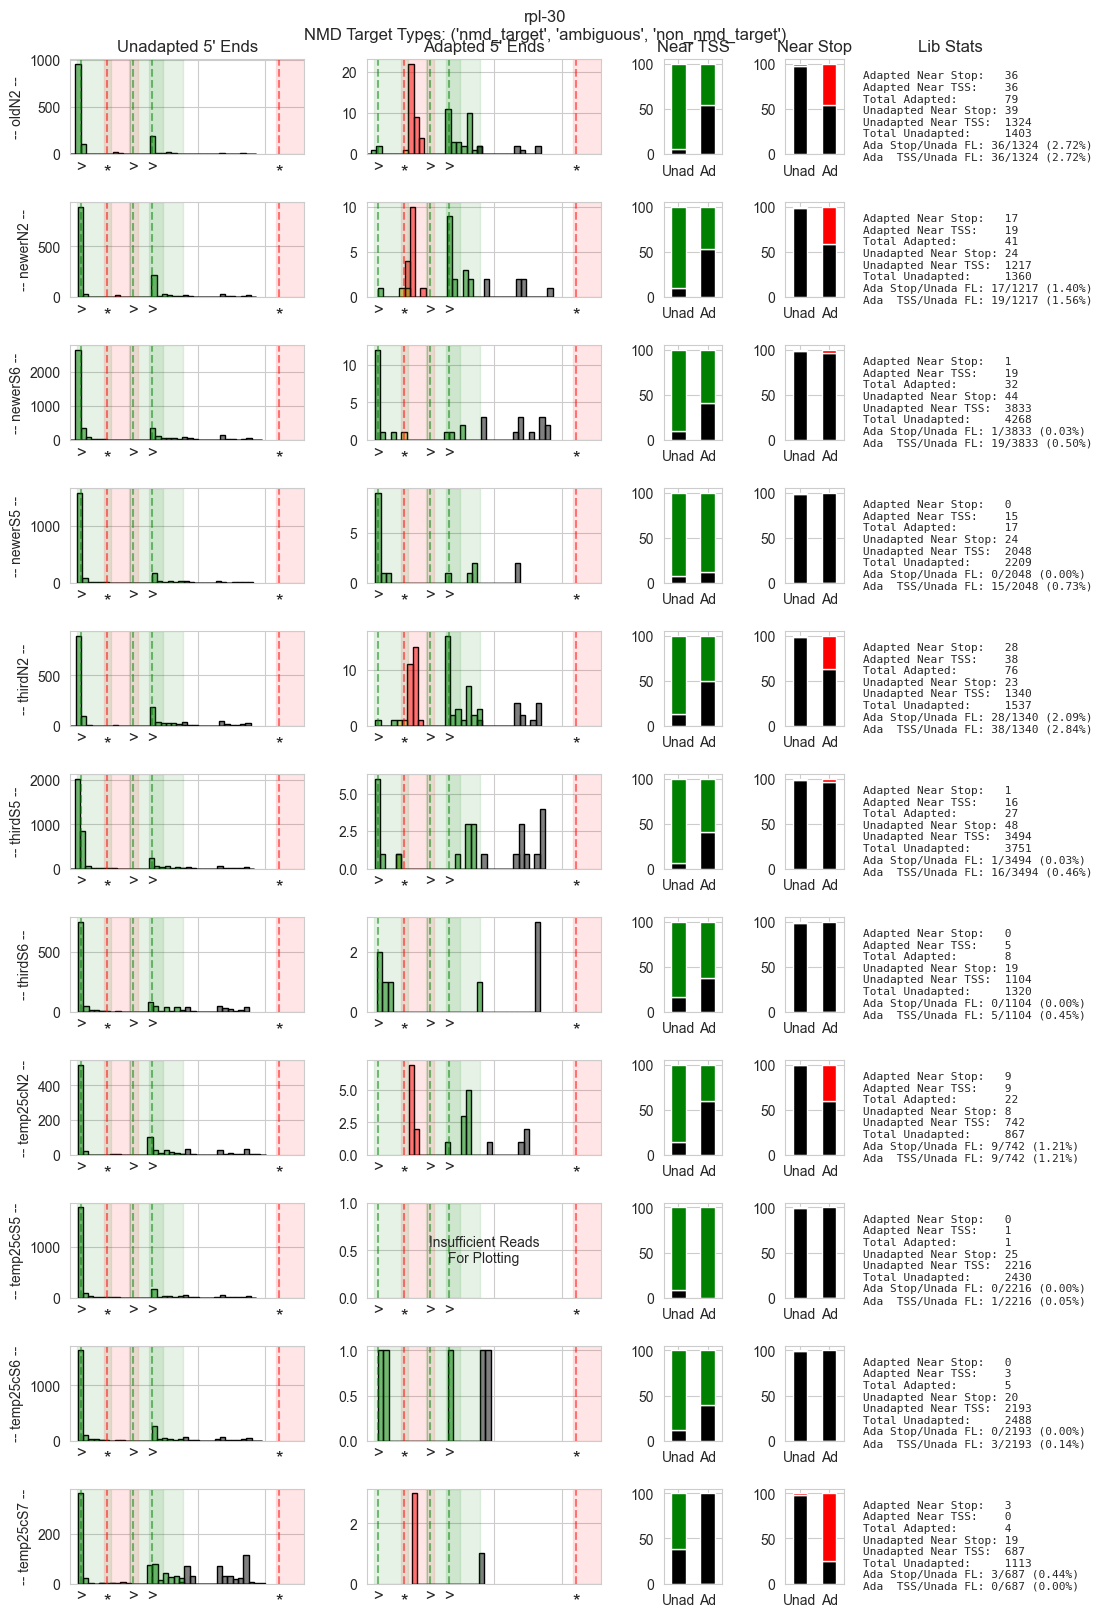

{'rps-22': {'NMD_Targets': {'oldN2': {'Adapted Near Stop': 15,
    'Adapted Near TSS': 0,
    'Total Adapted': 21,
    'Unadapted Near Stop': 15,
    'Unadapted Near TSS': 26,
    'Total Unadapted': 47},
   'newerN2': {'Adapted Near Stop': 5,
    'Adapted Near TSS': 0,
    'Total Adapted': 6,
    'Unadapted Near Stop': 10,
    'Unadapted Near TSS': 19,
    'Total Unadapted': 34},
   'newerS6': {'Adapted Near Stop': 6,
    'Adapted Near TSS': 0,
    'Total Adapted': 11,
    'Unadapted Near Stop': 143,
    'Unadapted Near TSS': 1227,
    'Total Unadapted': 1498},
   'newerS5': {'Adapted Near Stop': 5,
    'Adapted Near TSS': 1,
    'Total Adapted': 7,
    'Unadapted Near Stop': 87,
    'Unadapted Near TSS': 775,
    'Total Unadapted': 929},
   'thirdN2': {'Adapted Near Stop': 7,
    'Adapted Near TSS': 0,
    'Total Adapted': 13,
    'Unadapted Near Stop': 11,
    'Unadapted Near TSS': 17,
    'Total Unadapted': 36},
   'thirdS5': {'Adapted Near Stop': 8,
    'Adapted Near TSS': 4,
    '

In [8]:
window_size_for_search = 100  # 100nt seems to make sense (+50 and -50 from the TSS or STOP)
plot_genes = [
    'rps-22',
    'ubl-1',
    'rpl-30',
]
# plot_genes = nmd_genes

# plot_libs = [
#     "oldN2",
#     # "oldS6",
#     "newerN2",
#     "newerS6",
#     "newerS5",
#     "thirdN2",
#     "thirdS5",
#     "thirdS6",
#     "temp25cN2",
#     "temp25cS5",
#     "temp25cS6",
#     "temp25cS7",
# ]
plot_libs = libs_to_run

UNANNOTATED_TSS_DICT = {  # these are manual annotations of transcription start sites that are not in the GTF file
    'rpl-7A': [4_390_579, 4_390_464],
}

UNANNOTATED_STOPS_DICT = {  # these are manual annotations of stops that are not in the GTF file
    'rps-22': [1_950_853],  # cassette exon contains PTC
    'rpl-30': [10_436_332],  # extension of first exon contains PTC
    'rpl-7A': [4_389_880, 4_389_745],  # unannotated extension of 3rd exon contains PTC (second loc due to potential FS)
    'rsp-6': [7_790_576],  # longer unannotated form of cassette exon causes frame shift
    'C53H9.2': [1_833_467],  # shorter first exon leaves frame shift
    'pqn-70': [11_226_879],  # skipped exon leads to a frame change
    'rpl-1': [2_875_908],  # new orf started in the 3' extension of the first exon, causing a frame change
    'R06C1.4': [11_931_081],  # unannotated cassette exon contains a frame shift
    'rpl-3': [3_868_335],  # incorrectly annotated first intron 3' truncation (2nd exon extended) contains stop
    'hel-2': [8_327_970],  # later 5' SS adds to 3rd exon and contains PTC
    'rpl-12': [13_240_078],  # later 5' SS of second intron adds extension to 2nd exon with a PTC
    'aly-3': [12_123_859], # huge extension of second exon contains as PTC
}

def get_other_read_end(row):
    cigar = row['cigar']
    read_pos = row['chr_pos']
    if cigar is None:
        raise ValueError("Cigar is None!")
    if read_pos is None:
        raise ValueError("read_pos is None!")
    pattern = r"(\d*)([MDISN])"
    matches = re.findall(pattern, cigar)
    for match in matches:
        count, key = match
        if key in ['M', 'D', 'N']:
            read_pos += int(count)
    return read_pos

def near_a_tss_or_stop(row, _strand, tss_positions, stop_positions, col_for_pos='chr_pos', full_window_size=50, window_bias_downstream=0.50, make_window_correction=True) -> Tuple[bool, bool]:
    chr_pos = row[col_for_pos]
    if _strand == '-' and make_window_correction:
        window_bias_downstream = 1 - window_bias_downstream
    elif _strand != '+' and make_window_correction:
        raise ValueError(f"Strand must be '+' or '-' not {_strand}")
    
    near_tss = False
    near_stop = False
    chr_pos_upstream = chr_pos - full_window_size * (1 - window_bias_downstream)
    chr_pos_downstream = chr_pos + full_window_size * window_bias_downstream
    for tss in set(tss_positions):
        if chr_pos_upstream <= tss <= chr_pos_downstream:
            near_tss = True
            break
    for stop in set(stop_positions):
        if chr_pos_upstream <= stop <= chr_pos_downstream:
            near_stop = True
            break
    return near_tss, near_stop

def convert_near_tss_and_stop_to_hue(row, tss_color='g', stop_color='r', neither_color='k', both_color='y'):
    near_tss, near_stop = row['near_tss'], row['near_stop']
    if near_tss and near_stop:
        return both_color
    elif near_tss:
        return tss_color
    elif near_stop:
        return stop_color
    else:
        return neither_color

def plot_gene_data3(gtf_df, test_gene, plot_lib_df_dict, window_size=100,
                   up_v_down_fraction=0.10, number_of_bins=40,
                   flanking_gene_fraction=0.05, current_dir=None, print_stats=False,
                   title_override=None, save_name_override=None, show_plot=True):
    
    min_reads_cutoff = 3
    
    extra_stops_dict = UNANNOTATED_STOPS_DICT
    extra_tss_dict = UNANNOTATED_TSS_DICT
    
    gtf_for_gene = gtf_df.query("gene_name == @test_gene")
    gene_start, gene_end = gtf_for_gene.query("feature == 'gene'").loc[:, ['start', 'end']].values[0]
    gene_length = gene_end - gene_start
    bin_width = gene_length / number_of_bins
    flanking_dist = int(gene_length * flanking_gene_fraction)
    
    strand = gtf_for_gene.query("feature == 'gene'").loc[:, 'strand'].values[0]
    if print_stats:
        print(f"Gene target ({test_gene}) on strand: {strand}")
    if strand == '-':
        if print_stats:
            print("Because this gene is on the reverse strand, we will have to calculate out the other end of the reads with the CIGAR strings. This will take slightly longer.")
        stop_locations = gtf_for_gene.query("feature == 'stop_codon'").loc[:, 'end'].values
        start_sites = gtf_for_gene.query("feature == 'transcript'").loc[:, 'end'].values
        up_v_down_fraction = 1 - up_v_down_fraction
        flipped = True
    elif strand == '+':
        stop_locations = gtf_for_gene.query("feature == 'stop_codon'").loc[:, 'start'].values
        start_sites = gtf_for_gene.query("feature == 'transcript'").loc[:, 'start'].values
        flipped = False
    else:
        raise ValueError(f"Strand must be '+' or '-' not '{strand}'")
        
    stop_locations = list(stop_locations)
    start_sites = list(start_sites)
    
    if test_gene in extra_stops_dict:
        for stop_location in extra_stops_dict[test_gene]:
            stop_locations.append(stop_location)
    if test_gene in extra_tss_dict:
        for tss_location in extra_tss_dict[test_gene]:
            start_sites.append(tss_location)
    
    fig = plt.figure(figsize=(11, 1.5 * len(plot_lib_df_dict)))
    
    gs = fig.add_gridspec(len(plot_lib_df_dict), 5,
                          width_ratios=[4, 4, 1, 1, 1.5],
                          )
    summary_dict = {}
    for i, (lib, lib_df) in enumerate(plot_lib_df_dict.items()):

        if print_stats:
            print(f"\t{lib}:")
        ax1, ax2, ax3, ax4, ax5 = [fig.add_subplot(gs[i, j]) for j in range(5)]
        
        if i == 0:
            ax1.set_title("Unadapted 5' Ends")
            ax2.set_title("Adapted 5' Ends")
            ax3.set_title("Near TSS")
            ax4.set_title("Near Stop")
            ax5.set_title("Lib Stats")
        
        gene_df = lib_df.query('gene_name == @test_gene').copy()
        gene_df.replace({'t5': {0: '-', 1: '+', '+': '+', '-': '-'}}, inplace=True)
        if flipped:
            gene_df.loc[:, 'chr_pos'] = gene_df.apply(get_other_read_end, axis=1)
        gene_df.loc[:, 'near_tss'], gene_df.loc[:, 'near_stop'] = zip(*gene_df.apply(near_a_tss_or_stop, args=(strand, start_sites, stop_locations),
            full_window_size=window_size,window_bias_downstream=up_v_down_fraction, make_window_correction=False, axis=1))
        gene_df.loc[:, 'hue'] = gene_df.apply(convert_near_tss_and_stop_to_hue, axis=1)
        
        unadapted_df = gene_df.query('t5 == "-"').copy()
        adapted_df = gene_df.query('t5 == "+"').copy()
        
        # Create annotations to put in ax5
        ada_near_stop_count = adapted_df.query('near_stop').shape[0]
        ada_near_tss_count = adapted_df.query('near_tss').shape[0]
        unada_near_stop_count = unadapted_df.query('near_stop').shape[0]
        unada_near_tss_count = unadapted_df.query('near_tss').shape[0]
        ada_total_count = adapted_df.shape[0]
        unada_total_count = unadapted_df.shape[0]
        try:
            ada_stop_over_FL_string = f"{ada_near_stop_count}/{unada_near_tss_count} ({ada_near_stop_count/unada_near_tss_count:.2%})"
            ada_tss_over_FL_string = f"{ada_near_tss_count}/{unada_near_tss_count} ({ada_near_tss_count/unada_near_tss_count:.2%})"
        except ZeroDivisionError:
            ada_stop_over_FL_string = f"{ada_near_stop_count}/{unada_near_tss_count} (X.XX%)"
            ada_tss_over_FL_string = f"{ada_near_tss_count}/{unada_near_tss_count} (X.XX%)"
        ax5.axis('off')
        plot_string = (
            f"Adapted Near Stop:   {ada_near_stop_count}\n"
            f"Adapted Near TSS:    {ada_near_tss_count}\n"
            f"Total Adapted:       {ada_total_count}\n"
            f"Unadapted Near Stop: {unada_near_stop_count}\n"
            f"Unadapted Near TSS:  {unada_near_tss_count}\n"
            f"Total Unadapted:     {unada_total_count}\n"
            f"Ada Stop/Unada FL: {ada_stop_over_FL_string}\n"
            f"Ada  TSS/Unada FL: {ada_tss_over_FL_string}"
        )
        summary_dict[lib] = {
            'Adapted Near Stop': ada_near_stop_count,
            'Adapted Near TSS': ada_near_tss_count,
            'Total Adapted': ada_total_count,
            'Unadapted Near Stop': unada_near_stop_count,
            'Unadapted Near TSS': unada_near_tss_count,
            'Total Unadapted': unada_total_count,
        }
        try:
            unadapted_value_counts = unadapted_df['near_tss'].value_counts(normalize=True)
            if print_stats:
                print(f"\t\tUnadapted Read Distribution (near a TSS):")
                print(f"\t\t\t True: {unadapted_value_counts.get(True, 0.0):%}")
                print(f"\t\t\tFalse: {unadapted_value_counts.get(False, 0.0):%}")
            if unadapted_df.shape[0] > min_reads_cutoff:
                sea.histplot(data=unadapted_df,
                             x='chr_pos',
                             hue='hue',
                             palette={'r': 'r', 'g': 'g', 'k': 'k', 'y': 'y'},
                             binwidth=bin_width,
                             ax=ax1,
                             edgecolor='k', linewidth=1.0,
                             )
                ax1.get_legend().remove()
            else:
                ax1.text(0.5, 0.5, "Insufficient Reads\nFor Plotting", horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
                print(lib_obj.mergedOnReads_df.query('gene_name == @test_gene').head())
            ax1.set_ylabel(f"-- {lib} --")
            
            data_ct = pd.crosstab(index=gene_df['t5'], columns=gene_df['near_tss'])
            data_ct = data_ct.div(data_ct.sum(axis=1), axis=0) * 100
            data_ct.sort_index(ascending=False, inplace=True)
            
            color_dict = {True: 'g', False: 'k', None: 'y'}
            try:
                data_ct.plot(kind='bar',
                             stacked=True,
                             ax=ax3,
                             color=[color_dict[col] for col in data_ct.columns],
                             )
            except ValueError as e:
                print(f"Error: {e}")
                print(data_ct)
            ax3.set_ylabel ("") # ("% Near TSS")
            ax3.get_legend().remove()
            
            adapted_value_counts = adapted_df['near_stop'].value_counts(normalize=True)
            if print_stats:
                print(f"\t\tAdapted Read Distribution (near a STOP):")
                print(f"\t\t\t True: {adapted_value_counts.get(True, 0.0):%}")
                print(f"\t\t\tFalse: {adapted_value_counts.get(False, 0.0):%}")
            if adapted_df.shape[0] > min_reads_cutoff:
                sea.histplot(data=adapted_df,
                             x='chr_pos',
                             hue='hue',
                             palette={'r': 'r', 'g': 'g', 'k': 'k', 'y': 'y'},
                             binwidth=bin_width,
                             ax=ax2,
                             edgecolor='k', linewidth=1.0,
                             )
                ax2.get_legend().remove()
            else:
                ax2.text(0.5, 0.5, "Insufficient Reads\nFor Plotting", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
            
            ax2.set_ylabel(f"")
            
            data_ct = pd.crosstab(index=gene_df['t5'], columns=gene_df['near_stop'])
            data_ct = data_ct.div(data_ct.sum(axis=1), axis=0) * 100
            data_ct.sort_index(ascending=False, inplace=True)
            
            color_dict = {True: 'r', False: 'k', None: 'y'}
            try:
                data_ct.plot(kind='bar',
                             stacked=True,
                             ax=ax4,
                             color=[color_dict[col] for col in data_ct.columns],
                             )
            except ValueError as e:
                print(f"Error: {e}")
                print(data_ct)
            ax4.set_ylabel("")
            ax4.get_legend().remove()
            
            ax1.set_xlim(gene_start-flanking_dist, gene_end+flanking_dist)
            ax2.set_xlim(gene_start-flanking_dist, gene_end+flanking_dist)
            ax1.set_xlabel(f"")
            ax2.set_xlabel(f"")
            ax1.set_xticklabels([])
            ax2.set_xticklabels([])
            
            ax3.set_xlabel(f"")
            ax4.set_xlabel(f"")
            ax3.set_xticks([0 ,1], labels=['Unad', 'Ad'], rotation=0)
            ax4.set_xticks([0 ,1], labels=['Unad', 'Ad'], rotation=0)
            
            precompute_transforms = {ax1: ax1.get_xaxis_transform(),
                                     ax2: ax2.get_xaxis_transform()}
            for stop_loc in set(stop_locations):
                for ax in [ax1, ax2]:
                    ax.axvline(stop_loc, color='r', linestyle='--', alpha=0.5)
                    ax.axvspan(stop_loc-window_size*up_v_down_fraction,
                               stop_loc+window_size*(1-up_v_down_fraction),
                               color='r', alpha=0.1)
                    blend_transform = precompute_transforms[ax]
                    ax.text(stop_loc, -0.1, "*", rotation=0,
                            verticalalignment='top', horizontalalignment='center',
                            transform=blend_transform,
                            fontsize=14)
            for start_site in set(start_sites):
                for ax in [ax1, ax2]:
                    ax.axvline(start_site, color='g', linestyle='--', alpha=0.5)
                    ax.axvspan(start_site-window_size*up_v_down_fraction,
                               start_site+window_size*(1-up_v_down_fraction),
                               color='g', alpha=0.1)
                    blend_transform = precompute_transforms[ax]
                    if flipped:
                        tss_icon = "<"
                    else:
                        tss_icon = ">"
                    ax.text(start_site, -0.05, tss_icon, rotation=0,
                            verticalalignment='top', horizontalalignment='center',
                            transform=blend_transform,
                            fontsize=12)
            ax5.text(-0.5, 0.4, plot_string,
                     fontsize=8,
                     fontfamily='monospace',
                     horizontalalignment='left',
                     verticalalignment='center',
                     )
        except Exception as e:
            print(f"Error: {e}")
    if isinstance(title_override, str):
        plt.suptitle(title_override)
    else:
        plt.suptitle(f"{test_gene} ({strand} strand)")
    plt.tight_layout()
    if current_dir is not None:
        if isinstance(save_name_override, str):
            plt.savefig(current_dir / 'plots' / '5PrimeEndsPerGene' / f"{save_name_override}.png", dpi=300)
            plt.savefig(current_dir / 'plots' / '5PrimeEndsPerGene' / f"{save_name_override}.svg")
        else:
            plt.savefig(current_dir / 'plots' / '5PrimeEndsPerGene' / f"{test_gene}_5PrimeEnds.png", dpi=300)
            plt.savefig(current_dir / 'plots' / '5PrimeEndsPerGene' / f"{test_gene}_5PrimeEnds.svg")
    if show_plot:
        plt.show()
    return summary_dict


plot_lib_objs_dict = {lib: obj_dict[lib] for lib in plot_libs}
overall_summaries_nested_dict = {}
for gene in plot_genes:
    # if gene != "rpl-7A":
    #     continue
    print(f"{gene:#^50}")
    gene_summary_dicts = {}
    target_nmd_types = ('nmd_target', 'ambiguous', 'non_nmd_target')
    subset_nmd_types_list = [target_nmd_types[0], target_nmd_types[:2], target_nmd_types[2], target_nmd_types[:]]
    subset_nmd_types_names = ['NMD_Targets', 'NMD_TargetsAndAmbiguous', 'NMD_NonTargets', 'All_NMD_Types']
    
    for subset_nmd_types, subset_nmd_types_name in zip(subset_nmd_types_list, subset_nmd_types_names):
        try:
            lib_df_dict_for_gene = {lib: lib_obj.nmd_targets_df.query('gene_name == @gene & nmd_assignment in @subset_nmd_types') for lib, lib_obj in plot_lib_objs_dict.items()}
            summary_dict = plot_gene_data3(gtf_df, gene, lib_df_dict_for_gene, print_stats=False,
                                           title_override=f"{gene}\nNMD Target Types: {subset_nmd_types}",
                                           save_name_override=f"{gene}_{subset_nmd_types_name}",
                                           current_dir=current_dir,
                                           window_size=window_size_for_search,)
            gene_summary_dicts[subset_nmd_types_name] = summary_dict
        except Exception as e:
            print(f"Error: {e}")
            print(f"Gene: {gene}")
            print(f"NMD Types: {subset_nmd_types}")
            print(f"Continuing...")
    overall_summaries_nested_dict[gene] = gene_summary_dicts
overall_summaries_nested_dict

NameError: name 'overall_summaries_nested_dict' is not defined